Kress and Carmichael Iron Ratio calculation

[5.78712990e-17 2.30198345e-16 8.63748512e-16 3.06831402e-15
 1.03536137e-14 3.32889426e-14 1.02271700e-13 3.01019965e-13
 8.50884656e-13 2.31502180e-12 6.07506891e-12 1.54062660e-11
 3.78245007e-11 9.00543147e-11 2.08241884e-10 4.68376997e-10
 1.02607062e-09 2.19212567e-09 4.57274945e-09 9.32391068e-09
 1.86029886e-08 3.63545596e-08 6.96512225e-08 1.30939539e-07
 2.41736202e-07 4.38609130e-07]


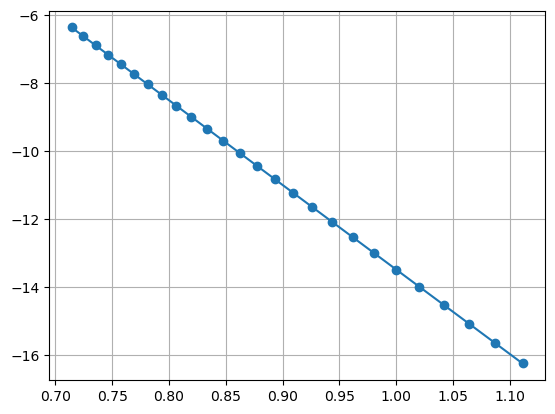

In [371]:
#Oxygen Buffer Reactions
#Cite: B.Fegley, Practical Chemical Thermodynamics for Geoscientists
import numpy as np
import matplotlib.pyplot as plt

#in Bars, at 2000 bars
#at temperature 1273.15K(equal to 1000C)
#using QFM+3 line -- SiO2, Fe2SiO4, Fe3O4 - Quartz, Fayallite, Magnetite

#Existing parameters for QFM
A = 5.5976 
B = 24505.0
C = 0.8099
D = 0.0937
T = np.linspace(900,1400,26)
P = 1

#Specific for the given samples
QFM_PlusThree = 3

Log_fO2 = A - (B/T) + C*np.log10(T) + ((D*(P-1))/T) + QFM_PlusThree
fO2 = 10 ** Log_fO2
print(fO2) #where the array is dependent on the Temperature distribution
plt.plot(1000/np.array(T), Log_fO2, marker = 'o', linestyle = '-')
plt.grid(True)
plt.show()

In [372]:
#K&C p.87 at table 7 Eq.7

In [373]:
#Calculation of the Iron Ratio in the Rock
#using QFM+3 line -- SiO2, Fe2SiO4, Fe3O4 - Quartz, Fayallite, Magnetite
#Kress and Carmichael 1991, Equation 7 and Parameter Values Table 7

#Parameters
a = 0.196
b = 1.1492 * np.power(10, 4)
c = -6.675
d_Al2O3 = -2.243
d_FeOtot = -1.828
d_CaO = 3.201
d_Na2O = 5.854
d_K2O = 6.215
e = -3.36
f = -7.01 * np.power(10.0, -7)
g =1.54 * np.power(10.0, -10)
h = 3.85 * np.power(10.0, -17)
T_0 = 1673 

In [374]:
weight_percent_to_moles = lambda weight_percent, molecular_weight: weight_percent / molecular_weight

molecular_weights = {
    'SiO2': 60.082,
    'TiO2': 79.866,
    'Al2O3': 101.96,
    'FeO': 71.84,
    'MnO': 70.9374,
    'MgO': 40.3044,
    'CaO': 56.08,
    'Na2O': 61.98,
    'K2O': 94.20,
    'P2O5': 283.889
}

weight_percents = {
    'SiO2': 55.08,
    'TiO2' : 0.72,
    'Al2O3': 15.16,
    'FeO': 7.76,
    'MnO': 0.16,
    'MgO': 7.63,
    'CaO': 8.43,
    'Na2O': 3.61,
    'K2O': 0.73,
    'P2O5': 0.16
}

moles = {key: weight_percent_to_moles(weight_percents[key], molecular_weights[key]) for key in weight_percents}
total_moles = sum(moles.values())
mole_fractions = {key: moles[key] / total_moles for key in moles}

SUM_dx = (mole_fractions['Al2O3'] * d_Al2O3) + (mole_fractions['FeO'] * d_FeOtot) + (mole_fractions['CaO'] * d_CaO) + (mole_fractions['Na2O'] * d_Na2O) + (mole_fractions['K2O'] * d_K2O)

components = list(mole_fractions.keys())
values = list(mole_fractions.values())

print(f"Al2O3 {mole_fractions['Al2O3']}", f"FeO {mole_fractions['FeO']}", f"CaO {mole_fractions['CaO']}", f"Na2O {mole_fractions['Na2O']}", f"K2O {mole_fractions['K2O']}")
plt.figure(figsize= (15, 9))
plt.bar(components, values, color='maroon')
plt.xlabel("Oxides")
plt.ylabel("Mole Fraction of Oxides")
plt.title("Melt Composition of 1704B")
plt.text(0.9, 0.14, '1704B Data A.Goltz 2022', fontsize = 12, color='g', alpha = 0.7)
plt.yticks(np.arange(0, 1.05, step=0.05))
plt.grid(True)
plt.show()

Al2O3 0.09345960835227536 FeO 0.0678969053009183 CaO 0.09448745508895497 Na2O 0.036610883734761616 K2O 0.004871094326719195


KeyboardInterrupt: 

In [ ]:
#Kress and Carmichael 1991 Equation 7

ln_IronRatio = a*np.log(fO2) + np.divide(b, T) + c + SUM_dx + e*(1 - np.divide(T_0, T) - np.log(np.divide(T, T_0))) + f*np.divide(P, T) + g*np.divide((P*T - P*T_0), T) + h*np.divide(P**2,T)

Text(0, 0.5, 'logfO2')

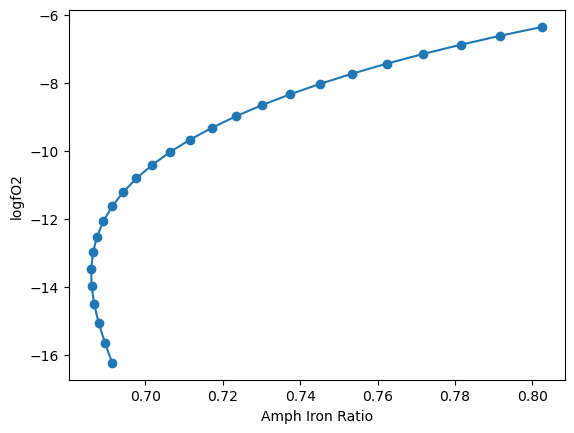

In [ ]:
IronRatio = np.exp(ln_IronRatio)
K_Iron = np.linspace(0.86,2.33,26)

#Goltz K value range table 3, equation p.2089
Amph_IronRatio = K_Iron * IronRatio
plt.plot(Amph_IronRatio, Log_fO2, marker = 'o')
plt.xlabel("Amph Iron Ratio")
plt.ylabel("logfO2")

code to get the ratio of ferrous to ferric iron is solved for. now we need to take that ratio and apply it to the epma data to determine how much of the iron is ferrous or ferric

In [ ]:
import pandas as pd
from fractions import Fraction

file_path = '/Users/tomassalazar/Desktop/Work/Krawcyzski Group/ESPM.Code/Petrology/Kamchatka/EPMA S.2 Analyses/EPMA RAW DATA.2/Tomas Salazar 7-22-2024 samples.xlsx'
sheet_name = '1704'

try:
    data = pd.read_excel(file_path, sheet_name=sheet_name)
except Exception as e:
    print(f"Error reading the Excel file: {e}")
    raise

data.columns = data.columns.str.strip()


#average of the iron amphibole ratio
def Average(Amph_IronRatio):
    return sum(Amph_IronRatio) / len(Amph_IronRatio)

def apply_ratio(whole_number, ratio_numerator, ratio_denominator):
    # calc the number of whole parts for numerator and denominator
    numerator_parts = whole_number * ratio_numerator / ratio_denominator
    denominator_parts = whole_number - numerator_parts
    return int(numerator_parts), int(denominator_parts)

Avg_AmphIronRatio = Average(Amph_IronRatio)
ratio = Fraction(Avg_AmphIronRatio).limit_denominator()
numerator = ratio.numerator
denominator = ratio.denominator
FeOtot_Data = data['FeO']

def apply_ratio_to_data(data, numerator, denominator):
    numerator_part = data * numerator / denominator
    denominator_part = data - numerator_part
    return numerator_part, denominator_part

numerator_parts, denominator_parts = apply_ratio_to_data(FeOtot_Data, numerator, denominator)

print(f"Num (Fe2O3 data):\n{numerator_parts}")


Num (Fe2O3 data):
0     8.377301
1     8.042321
2     8.080533
3     8.112556
4     8.647732
5     8.292675
6     8.159690
7     9.293800
8     9.222702
9     7.798732
10    8.478551
11    8.258277
12    8.457970
13    8.656799
14    9.625110
15    8.056786
16    8.367730
17    9.680592
18    8.034118
19    6.900231
20    8.313543
21    7.992164
22    8.612255
23    8.093198
24    8.552527
25    6.804026
Name: FeO, dtype: float64


In [ ]:
import pandas as pd
from fractions import Fraction

file_path = '/Users/tomassalazar/Desktop/Work/Krawcyzski Group/ESPM.Code/Petrology/Kamchatka/EPMA S.2 Analyses/EPMA RAW DATA.2/Tomas Salazar 7-22-2024 samples.xlsx'
sheet_name = '1704'

try:
    data = pd.read_excel(file_path, sheet_name=sheet_name)
except Exception as e:
    print(f"Error reading the Excel file: {e}")
    raise

data.columns = data.columns.str.strip()

def apply_ratio(whole_number, ratio_numerator, ratio_denominator):
    # calc the number of whole parts for numerator and denominator
    numerator_parts = whole_number * ratio_numerator / ratio_denominator
    denominator_parts = whole_number - numerator_parts
    return int(numerator_parts), int(denominator_parts)


ratio = Fraction(Amph_IronRatio).limit_denominator()
numerator = ratio.numerator
denominator = ratio.denominator
FeOtot_Data = data['FeO']

def apply_ratio_to_data(data, numerator, denominator):
    numerator_part = data * numerator / denominator
    denominator_part = data - numerator_part
    return numerator_part, denominator_part

for ratio_str in Amph_IronRatio:
    ratio = Fraction(ratio_str).limit_denominator()
    numerator = ratio.numerator
    denominator = ratio.denominator

    numerator_parts, denominator_parts = apply_ratio_to_data(FeOtot_Data, numerator, denominator)
    plt.plot(numerator_parts, denominator_parts, label=f'Ratio {ratio_str}')

TypeError: argument should be a string or a Rational instance

Xiaoyan Li, Chao Zhang, Harald Behrens, Francois Holtz 

speadsheet calculation from machine learning, written as SS

In [ ]:
file_path = '/Users/tomassalazar/Desktop/Work/Krawcyzski Group/ESPM.Code/Petrology/Kamchatka/EPMA S.2 Analyses/Misc/amphsitelocator.xlsx'
sheet_name = 'AMPH-SITE-LOCATOR'

try:
    data = pd.read_excel(file_path, sheet_name=sheet_name)
except Exception as e:
    print(f"Error reading the Excel file: {e}")
    raise

data.columns = data.columns.str.strip()
#because the column names cannot be named, the column numbers will be use and the names of them are 'Unnamed: #'
datafeocalc = data['Unnamed: 26'].iloc[1:27]
datafe2O3calc = data['Unnamed: 25'].iloc[1:27]

print(f"FeO:\n{datafeocalc}")
print(f"Fe2O3:\n{datafe2O3calc}")


FeO:
1     7.965429
2     7.491492
3     7.693443
4     7.652203
5     8.354323
6     7.883889
7     7.567634
8     8.750066
9     8.719973
10    7.070294
11    7.409012
12    7.931029
13    8.153105
14     8.27936
15     9.24243
16     7.93559
17    8.215982
18    9.509227
19    7.882707
20    5.863495
21    8.046355
22    7.835169
23    8.290368
24    7.908869
25    8.632495
26    4.939144
Name: Unnamed: 26, dtype: object
Fe2O3:
1     4.085214
2      4.09459
3     3.929167
4     4.024453
5     4.070662
6      4.04514
7     4.191229
8     4.628613
9     4.552257
10    4.186495
11     4.85994
12     3.93963
13    4.001224
14    4.167973
15     4.59309
16    3.623389
17    3.791986
18    4.382274
19    3.647152
20    4.140051
21    3.896815
22    3.635192
23    4.086949
24    3.709317
25    3.614493
26    5.018736
Name: Unnamed: 25, dtype: object


now for the john locock amph iron calculation

Now find a reasonable ratio for the amphibole to match the machine learning spreadsheet

In [ ]:
import pandas as pd
from fractions import Fraction

file_path = '/Users/tomassalazar/Desktop/Work/Krawcyzski Group/ESPM.Code/Petrology/Kamchatka/EPMA S.2 Analyses/EPMA RAW DATA.2/Tomas Salazar 7-22-2024 samples.xlsx'
sheet_name = '1704'

try:
    data = pd.read_excel(file_path, sheet_name=sheet_name)
except Exception as e:
    print(f"Error reading the Excel file: {e}")
    raise

data.columns = data.columns.str.strip()

AIR = Amph_IronRatio[(16)]
print(AIR)

def apply_ratio(whole_number, ratio_numerator, ratio_denominator):
    # Calculate the number of whole parts for numerator and denominator
    numerator_parts = whole_number * ratio_numerator / ratio_denominator
    denominator_parts = whole_number - numerator_parts
    return int(numerator_parts), int(denominator_parts)

Avg_AmphIronRatio = Average(Amph_IronRatio)
ratio = Fraction(AIR).limit_denominator()
numerator = ratio.numerator
denominator = ratio.denominator
FeOtot_Data = data['FeO']

def apply_ratio_to_data(data, numerator, denominator):
    numerator_part = data * numerator / denominator
    denominator_part = data - numerator_part
    return numerator_part, denominator_part

AIRnumerator_parts, AIRdenominator_parts = apply_ratio_to_data(FeOtot_Data, numerator, denominator)

print(f"Num (Fe2O3 data):\n{AIRnumerator_parts}")
print(f"Num (FeO data):\n{AIRdenominator_parts}")



0.7233354569924263
Num (Fe2O3 data):
0     8.420637
1     8.083925
2     8.122334
3     8.154522
4     8.692467
5     8.335573
6     8.201901
7     9.341877
8     9.270412
9     7.839076
10    8.522411
11    8.300998
12    8.501723
13    8.701581
14    9.674901
15    8.098464
16    8.411017
17    9.730670
18    8.075679
19    6.935926
20    8.356550
21    8.033508
22    8.656806
23    8.135065
24    8.596770
25    6.839224
Name: FeO, dtype: float64
Num (FeO data):
0     3.220763
1     3.091975
2     3.106666
3     3.118978
4     3.324733
5     3.188227
6     3.137099
7     3.573123
8     3.545788
9     2.998324
10    3.259689
11    3.175002
12    3.251777
13    3.328219
14    3.700499
15    3.097536
16    3.217083
17    3.721830
18    3.088821
19    2.652884
20    3.196250
21    3.072692
22    3.311094
23    3.111535
24    3.288130
25    2.615896
Name: FeO, dtype: float64


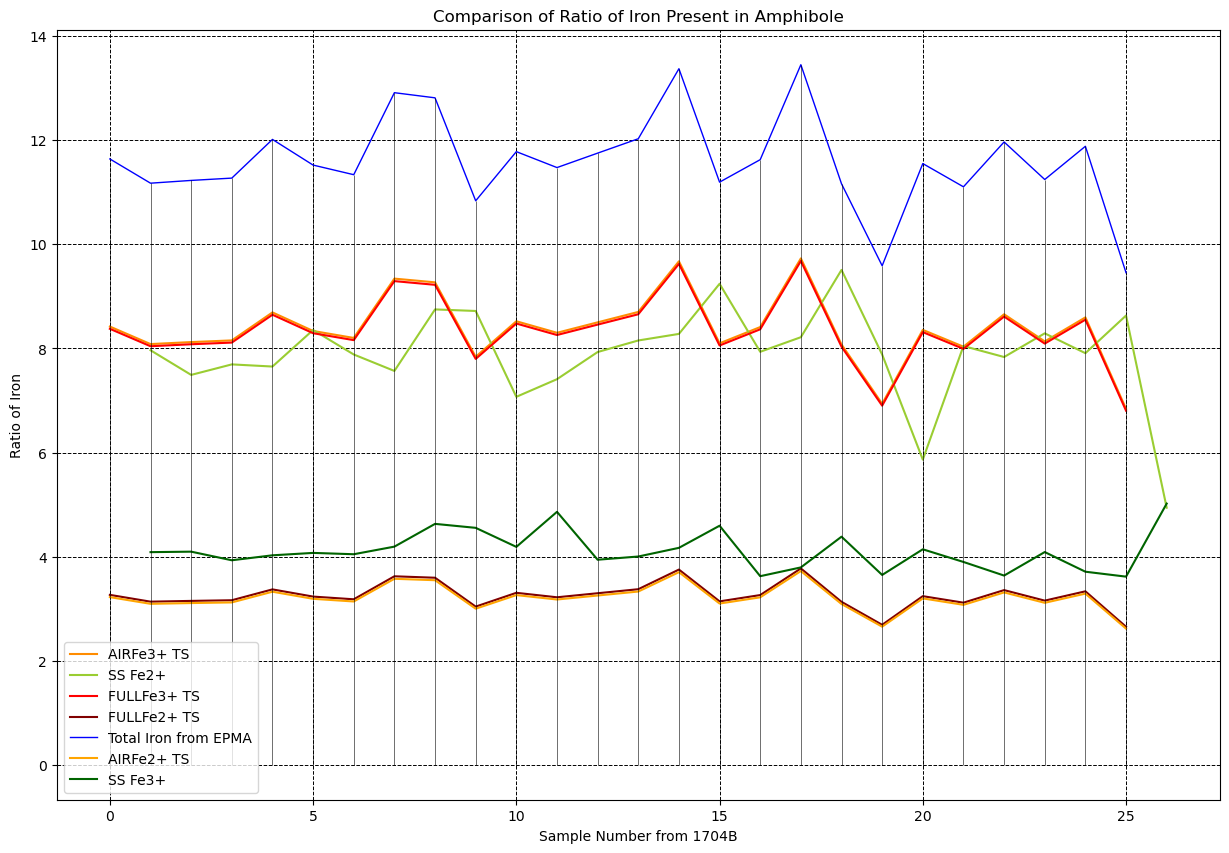

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(AIRnumerator_parts, color = 'darkorange', label = "AIRFe3+ TS")
plt.plot(datafeocalc, color = 'yellowgreen', label = "SS Fe2+")
plt.plot(numerator_parts, color = 'red', label = "FULLFe3+ TS")
plt.plot(denominator_parts, c = 'maroon', label = "FULLFe2+ TS")
plt.plot(FeOtot_Data, color = 'blue', linewidth = 1.0, label = "Total Iron from EPMA")
plt.plot(AIRdenominator_parts, c = 'orange', label = "AIRFe2+ TS")
plt.plot(datafe2O3calc, c = 'darkgreen', label = "SS Fe3+")

for i, value in enumerate(FeOtot_Data):
    plt.vlines(x=i, ymin=0, ymax=value, color='black', linewidth=0.4)

plt.legend()

plt.xlabel("Sample Number from 1704B")
plt.ylabel("Ratio of Iron")
plt.title("Comparison of Ratio of Iron Present in Amphibole")

plt.grid(c = 'black', ls = '--', linewidth = 0.7)
plt.show()


In [ ]:
AGoltzcheck = AIRnumerator_parts / np.average(FeOtot_Data) * 100
print(np.average(AGoltzcheck) * np.average(FeOtot_Data))
print(np.average)

838.5923685814785
<function average at 0x1088ea170>


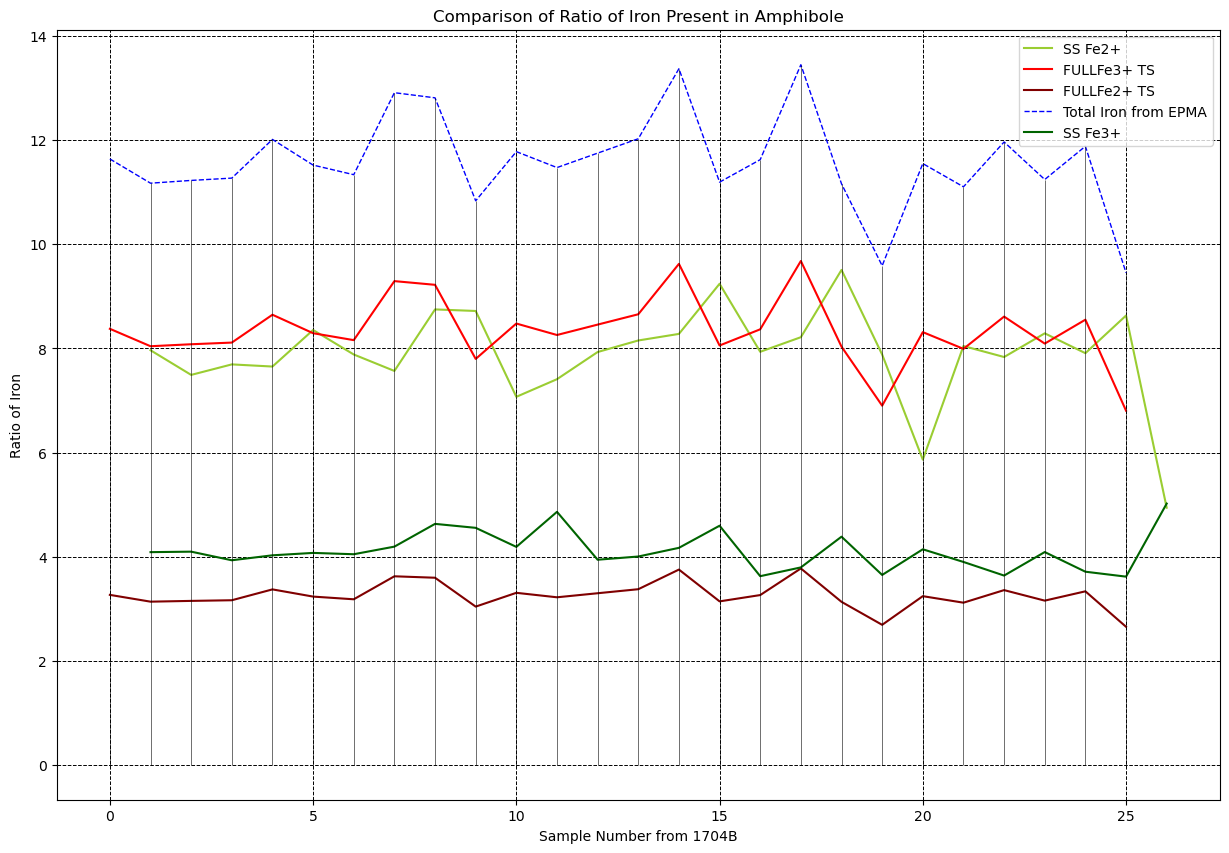

In [375]:
plt.figure(figsize = (15,10))

plt.plot(datafeocalc, color = 'yellowgreen', label = "SS Fe2+")
plt.plot(numerator_parts, color = 'red', label = "FULLFe3+ TS")
plt.plot(denominator_parts, c = 'maroon', label = "FULLFe2+ TS")
plt.plot(FeOtot_Data, color = 'blue', linewidth = 1.0, label = "Total Iron from EPMA", ls = '--')
plt.plot(datafe2O3calc, c = 'darkgreen', label = "SS Fe3+")

for i, value in enumerate(FeOtot_Data):
    plt.vlines(x=i, ymin=0, ymax=value, color='black', linewidth=0.4)

plt.legend()

plt.xlabel("Sample Number from 1704B")
plt.ylabel("Ratio of Iron")
plt.title("Comparison of Ratio of Iron Present in Amphibole")

plt.grid(c = 'black', ls = '--', linewidth = 0.7)
plt.show()
